In [1]:
import scanpy as sc
import pandas as pd 
import numpy as np
import sys
import matplotlib.pyplot as plt
import gc
import anndata
from adjustText import adjust_text
import seaborn as sns
from scipy.stats import mannwhitneyu
import magic

def grouped_obs_sum_raw(adata_filt, group_key, layer=None, gene_symbols=None):
    if layer is not None:
        getX = lambda x: x.layers[layer]
    else:
        getX = lambda x: x.X
    if gene_symbols is not None:
        idx = adata_filt.var_names.isin(gene_symbols)
        new_idx = adata_filt.var_names[idx]
    else:
        new_idx = adata_filt.var_names
    grouped = adata_filt.obs.groupby(group_key)
    out = pd.DataFrame(
        np.zeros((len(new_idx), len(grouped)), dtype=np.float64),
        columns=list(grouped.groups.keys()),
        index=new_idx
    )
    for group, idx in grouped.indices.items():
        X = getX(adata_filt[idx])
        out[group] = np.ravel(X.sum(axis=0, dtype=np.float64))
    return out

def grouped_obs_mean(adata_filt, group_key, layer=None, gene_symbols=None):
    if layer is not None:
        getX = lambda x: x.layers[layer]
    else:
        getX = lambda x: x.X
    if gene_symbols is not None:
        idx = adata_filt.var_names.isin(gene_symbols)
        new_idx = adata_filt.var_names[idx]
    else:
        new_idx = adata_filt.var_names
    grouped = adata_filt.obs.groupby(group_key)
    out = pd.DataFrame(
        np.zeros((len(new_idx), len(grouped)), dtype=np.float64),
        columns=list(grouped.groups.keys()),
        index=new_idx
    )
    for group, idx in grouped.indices.items():
        X = getX(adata_filt[idx])
        out[group] = np.ravel(X.mean(axis=0, dtype=np.float64))
    return out

/home/workspace/Aux_Envir/Python_BRI_Figures/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/workspace/Aux_Envir/Python_BRI_Figures/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/workspace/Aux_Envir/Python_BRI_Figures/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/workspace/Aux_Envir/Python_BRI_Figures/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/workspace/Aux_Envir/Python_BRI_Figures/lib/python3.11/site-p

In [2]:
adata=sc.read_h5ad("adata_processed.h5ad")

In [3]:
adata.obs['sample']=[x + "_" + y for x, y in zip(adata.obs['donor'], adata.obs['days'])]

In [4]:
adata.obs["AIFI_L3"].unique()

['Core naive B cell', 'Core memory B cell', 'Activated memory B cell', 'Core naive CD4 T cell', 'CD27- effector B cell', ..., 'pDC', 'Core CD14 monocyte', 'ISG+ naive B cell', 'Core naive CD8 T cell', 'Erythrocyte']
Length: 17
Categories (17, object): ['Activated memory B cell', 'CD14+ cDC2', 'CD27+ effector B cell', 'CD27- effector B cell', ..., 'Plasma cell', 'Platelet', 'Transitional B cell', 'pDC']

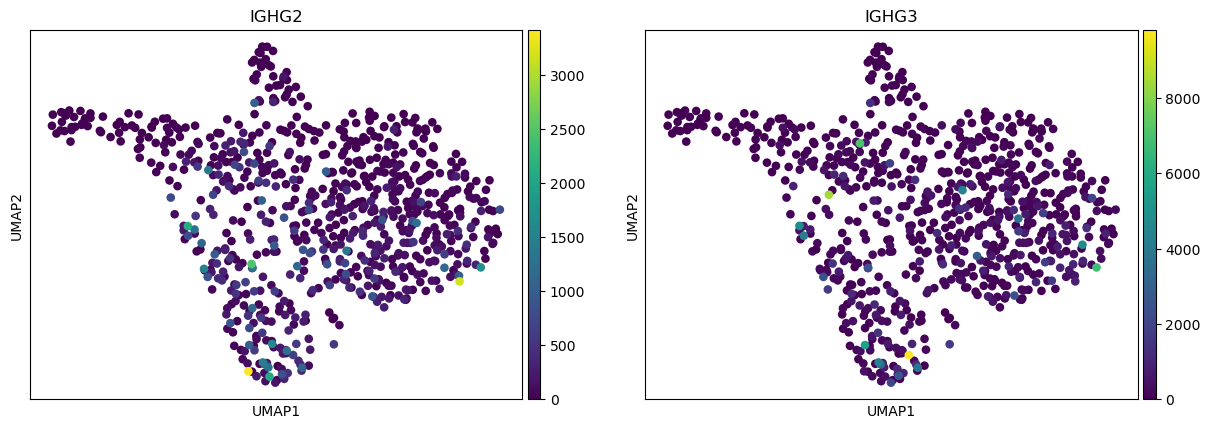

In [10]:
sc.pl.umap(adata, color=['IGHG2',"IGHG3"],ncols=3)


#  CD27- effector B


/tmp/ipykernel_6468/385656859.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = adata_filt.obs.groupby(group_key)
/home/workspace/Aux_Envir/Python_BRI_Figures/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/tmp/ipykernel_6468/385656859.py:44: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = adata_filt.obs.groupby(group_key)
/tmp/ipykernel_6468/2460741726.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` var

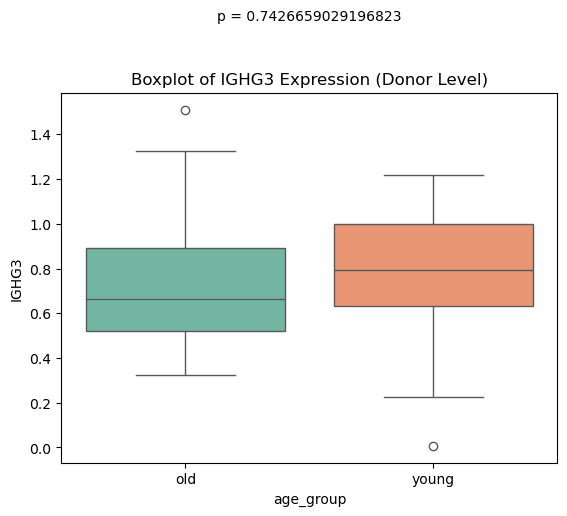

/tmp/ipykernel_6468/2460741726.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='age_group', y=gene_name, data=gene_expression_df, palette='Set2')


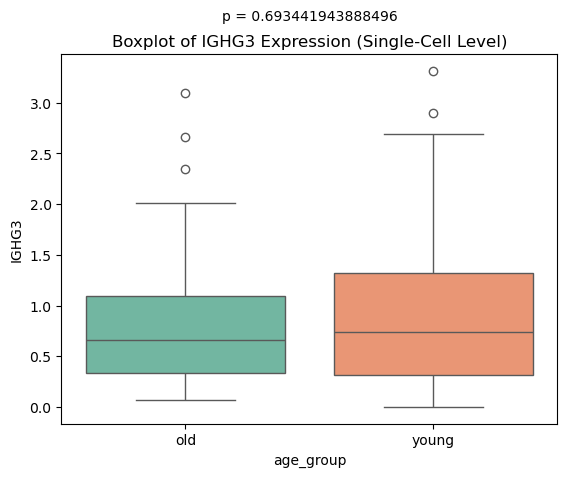

In [11]:
gene_name = 'IGHG3'

adata_subset = adata[adata.obs["AIFI_L3"] == "CD27- effector B cell"]
#adata_subset=adata_subset[adata_subset.obs["days"]=="d0"]

raw_count_sum = grouped_obs_sum_raw(adata_subset, "sample")
sc.pp.normalize_total(adata_subset, target_sum=1e4)
sc.pp.log1p(adata_subset)
normalized_count_average = grouped_obs_mean(adata_subset, "sample")

df_exp = pd.DataFrame(normalized_count_average.loc[gene_name, :])
metadata = adata_subset.obs[["sample", "days","donor", "age_group"]].drop_duplicates()
metadata.index = metadata['sample'].tolist()

merged_df = pd.merge(df_exp, metadata, left_index=True, right_index=True)

stat, p_value = mannwhitneyu(
    merged_df[merged_df['age_group'] == 'old'][gene_name],
    merged_df[merged_df['age_group'] == 'young'][gene_name]
)

sns.boxplot(x='age_group', y=gene_name, data=merged_df, palette='Set2')
plt.text(0.5, merged_df[gene_name].max() + 0.4, f'p = {p_value}', ha='center')
plt.title(f'Boxplot of {gene_name} Expression (Donor Level)')
plt.show()

gene_expression = pd.DataFrame(adata_subset[:, gene_name].X, columns=[gene_name])
gene_expression["sample"] = adata_subset.obs["sample"].tolist()
gene_expression.index = gene_expression['sample'].tolist()

gene_expression_df = pd.merge(gene_expression, metadata, left_index=True, right_index=True)

stat, p_value = mannwhitneyu(
    gene_expression_df[gene_expression_df['age_group'] == 'old'][gene_name],
    gene_expression_df[gene_expression_df['age_group'] == 'young'][gene_name]
)

sns.boxplot(x='age_group', y=gene_name, data=gene_expression_df, palette='Set2')
plt.text(0.5, gene_expression_df[gene_name].max() + 0.5, f'p = {p_value}', ha='center')
plt.title(f'Boxplot of {gene_name} Expression (Single-Cell Level)')
plt.show()